# **PerAct**
### Annotated Tutorial

**Important: Before starting, change the runtime to GPU.**

This notebook is an annotated tutorial on training [Perceiver-Actor (PerAct)](https://peract.github.io/) from scratch. We will look at training a single-task agent on the `open_drawer` task.  The tutorial will start from loading calibrated RGB-D images, and end with visualizing *action detections* in voxelized observations. Overall, this guide is
meant to complement the [paper](https://peract.github.io/) by providing concrete implementation details.  

### Full Code
See [this Github repository](https://github.com/peract/peract) for the full code, pre-trained checkpoints, and pre-generated datasets. You should be able to use the pre-generated datasets with this notebook.

### Credit
This notebook heavily builds on data-loading and pre-preprocessing code from [`ARM`](https://github.com/stepjam/ARM), [`YARR`](https://github.com/stepjam/YARR), [`PyRep`](https://github.com/stepjam/PyRep), [`RLBench`](https://github.com/stepjam/RLBench) by [James et al.](https://stepjam.github.io/) The [PerceiverIO](https://arxiv.org/abs/2107.14795) code is adapted from [`perceiver-pytorch`](https://github.com/lucidrains/perceiver-pytorch) by [Phil Wang (lucidrains)](https://github.com/lucidrains). The optimizer is based on [this LAMB implementation](https://github.com/cybertronai/pytorch-lamb). See the corresponding licenses below.

<img src="https://peract.github.io/media/figures/sim_task.jpg" alt="drawing" style="width:100px;"/>

### Licenses
- [PerAct License (Apache 2.0)](https://github.com/peract/peract/blob/main/LICENSE) - Perceiver-Actor Transformer
- [ARM License](https://github.com/peract/peract/blob/main/ARM_LICENSE) - Voxelization and Data Preprocessing
- [YARR Licence (Apache 2.0)](https://github.com/stepjam/YARR/blob/main/LICENSE)
- [RLBench Licence](https://github.com/stepjam/RLBench/blob/master/LICENSE)
- [PyRep License (MIT)](https://github.com/stepjam/PyRep/blob/master/LICENSE)
- [Perceiver PyTorch License (MIT)](https://github.com/lucidrains/perceiver-pytorch/blob/main/LICENSE)
- [LAMB License (MIT)](https://github.com/cybertronai/pytorch-lamb/blob/master/LICENSE)
- [CLIP License (MIT)](https://github.com/openai/CLIP/blob/main/LICENSE)


### Install Dependencies

In [ ]:
!pip install scipy ftfy regex tqdm torch git+https://github.com/openai/CLIP.git einops pyrender==0.1.45 trimesh==3.9.34 pycollada==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4ilvxcd7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-4ilvxcd7
     |████████████████████████████████| 26.1 MB 1.8 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 1.2 MB 58.9 MB/s 
     |████████████████████████████████| 638 kB 66.9 MB/s 
     |████████████████████████████████| 103 kB 73.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 978 kB 61.5 MB/s 
     |████████████████████████████████| 2.2 MB 48.1 MB/s 
     |████████████████████████████████| 19.1 MB 918 kB/s 
     |████████████████████████████████| 19.1 MB 1.1 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |███████████████████████████████

### Clone Repo and Setup

Clone [https://github.com/peract/peract_colab.git](github.com/peract/peract_colab.git).   

This repo contains barebones code from [`ARM`](https://github.com/stepjam/ARM), [`YARR`](https://github.com/stepjam/YARR), [`PyRep`](https://github.com/stepjam/PyRep), [`RLBench`](https://github.com/stepjam/RLBench) to get started with  PerAct without the actual [V-REP](https://www.coppeliarobotics.com/) simulator.

The repo also contains a pre-generated RLBench dataset of 10 expert demonstrations for the `open_drawer` task. This task has three variations: "open the top drawer", "open the middle drawer", and "open the bottom drawer"



In [ ]:
!git clone https://github.com/peract/peract_colab.git

Cloning into 'peract_colab'...
remote: Enumerating objects: 16373, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 16373 (delta 92), reused 134 (delta 49), pack-reused 16193
Receiving objects: 100% (16373/16373), 178.97 MiB | 32.22 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Checking out files: 100% (16260/16260), done.


If you fork-off this repo, you might want to pull the latest changes.

In [ ]:
!cd peract_colab && git pull origin master

From https://github.com/peract/peract_colab
 * branch            master     -> FETCH_HEAD
Already up to date.


Set `PYOPENGL_PLATFORM=egl` for pyrender visualizations

In [ ]:
import numpy as np
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

Define some constants and setting variables.

The `BATCH_SIZE` is 1 to fit the model on a single GPU. But you can play around with the voxel sizes and Transformer layers to increase this.  

In the paper, we use `NUM_LATENTS=2048` by default, but smaller latents like `512` are also fine (see Appendix G).

In [ ]:
# constants
TASK = 'open_drawer'
DATA_FOLDER ='peract_colab/data'
EPISODES_FOLDER = 'colab_dataset/open_drawer/all_variations/episodes'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents
SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6] # [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
BATCH_SIZE = 1
NUM_DEMOS = 8 # total number of training demonstrations to use while training PerAct
NUM_TEST = 2 # episodes to evaluate on

Add `peract_colab` to the system path and make a directory for storing the replay buffer.  For now, we will store the replay buffer on disk to avoid memory issues with putting everthing on RAM.

In [ ]:
sys.path.append('peract_colab')
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

## Data Loading & Preprocessing

An expert demonstration recorded at ~20Hz contains 100s of individual timesteps in a sequence. Each timestep contains observations recorded from 4 calibrated cameras (front, left_shoulder, right_shoulder, and wrist) and other proprioception sensors. "Calibrated" means we know the extrinsics and intrinsics.

Let's take a look at what these observations look like. Play around with different `episode_idx_to_visualize` and timesteps `ts`.

Demo 1 | 108 total steps



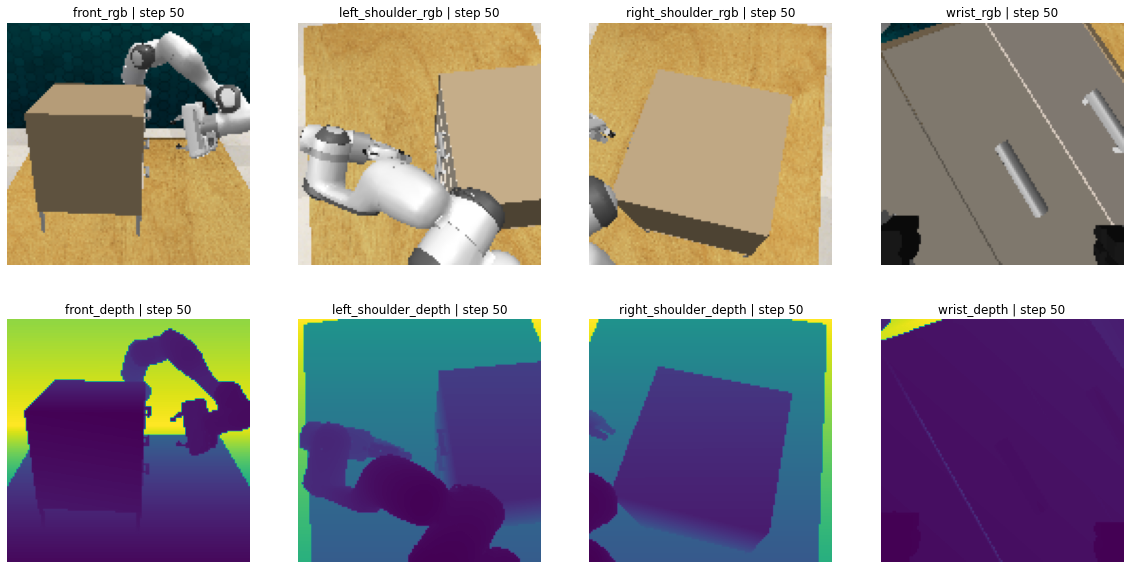

In [ ]:
from rlbench.utils import get_stored_demo
from rlbench.backend.utils import extract_obs

# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = 50 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# extract obs at timestep
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

### Create Replay Buffer

As described in **Section 3.4** of the paper, PerAct is trained with discrete-time input-action tuples from a dataset of demonstrations. These tuples are stored in a Replay Buffer following the [`ARM`](https://github.com/stepjam/ARM) codebase. You can use your own storage format, but here we follow `ARM` to benchmark against baselines and other methods by James et al.

This replay buffer stores **<observation, language goal, keyframe action>** tuples sampled from demonstrations.

In [ ]:
# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/c2farm/launch_utils.py

from yarr.utils.observation_type import ObservationElement
from yarr.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer


def create_replay(batch_size: int,
                  timesteps: int,
                  save_dir: str,
                  cameras: list,
                  voxel_sizes,
                  replay_size=3e5):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512

    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32)) # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_embs', (max_token_seq_len, lang_emb_dim,), # extracted from CLIP's language encoder
                      np.float32),
        ReplayElement('lang_goal', (1,), object), # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]

    replay_buffer = UniformReplayBuffer( # all tuples in the buffer have equal sample weighting
        save_dir=save_dir,
        batch_size=batch_size,
        timesteps=timesteps,
        replay_capacity=int(replay_size),
        action_shape=(8,), # 3 translation + 4 rotation quaternion + 1 gripper open
        action_dtype=np.float32,
        reward_shape=(),
        reward_dtype=np.float32,
        update_horizon=1,
        observation_elements=observation_elements,
        extra_replay_elements=extra_replay_elements
    )
    return replay_buffer

train_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                    timesteps=1,
                                    save_dir=train_replay_storage_dir,
                                    cameras=CAMERAS,
                                    voxel_sizes=VOXEL_SIZES)

test_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                   timesteps=1,
                                   save_dir=test_replay_storage_dir,
                                   cameras=CAMERAS,
                                   voxel_sizes=VOXEL_SIZES)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Fill Replay with Demos

#### Keyframe Extraction

Instead of directly trying to predict every action in the demonstration, which could be very noisy and inefficient, we extract keyframe actions that capture **bottleneck** poses \[[James et al.](https://arxiv.org/abs/2105.14829)\]. This extraction is done with a simple heuristic: an action is a keyframe action if (1) the joint-velocities are near zero and (2) the gripper open state has not changed. Then every timestep in the demonstration can be cast as a predict "the next (best) keyframe" classification task, like the orange points in this figure:  

<div>
<img src="https://peract.github.io/media/figures/keypoints.jpg" alt="drawing"  width="300"/>
</div>

In [ ]:
# From https://github.com/stepjam/ARM/blob/main/arm/demo_loading_utils.py

from rlbench.demo import Demo
from typing import List

def _is_stopped(demo, i, obs, stopped_buffer, delta=0.1):
    next_is_not_final = i == (len(demo) - 2)
    gripper_state_no_change = (
            i < (len(demo) - 2) and
            (obs.gripper_open == demo[i + 1].gripper_open and
             obs.gripper_open == demo[i - 1].gripper_open and
             demo[i - 2].gripper_open == demo[i - 1].gripper_open))
    small_delta = np.allclose(obs.joint_velocities, 0, atol=delta)
    stopped = (stopped_buffer <= 0 and small_delta and
               (not next_is_not_final) and gripper_state_no_change)
    return stopped

def _keypoint_discovery(demo: Demo,
                        stopping_delta=0.1) -> List[int]:
    episode_keypoints = []
    prev_gripper_open = demo[0].gripper_open
    stopped_buffer = 0
    for i, obs in enumerate(demo):
        stopped = _is_stopped(demo, i, obs, stopped_buffer, stopping_delta)
        stopped_buffer = 4 if stopped else stopped_buffer - 1
        # if change in gripper, or end of episode.
        last = i == (len(demo) - 1)
        if i != 0 and (obs.gripper_open != prev_gripper_open or
                        last or stopped):
            episode_keypoints.append(i)
        prev_gripper_open = obs.gripper_open
    if len(episode_keypoints) > 1 and (episode_keypoints[-1] - 1) == \
            episode_keypoints[-2]:
        episode_keypoints.pop(-2)
    print('Found %d keypoints.' % len(episode_keypoints), episode_keypoints)
    return episode_keypoints

Let's take a look at what these keyframe actions look like.  



Demo 1 | 108 total steps
Found 3 keypoints. [64, 77, 107]


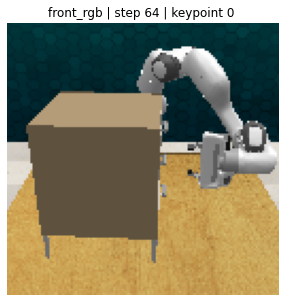

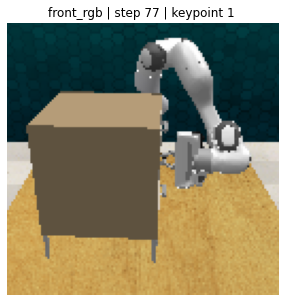

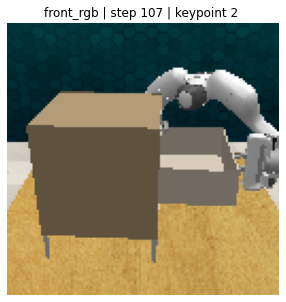

In [ ]:
# use Demo 1 like last time
episode_idx_to_visualize = 1
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations)))

# use the heuristic to extract keyframes (aka keypoints)
episode_keypoints = _keypoint_discovery(demo)

# visualize rgb observations from these keyframes
for kp_idx, kp in enumerate(episode_keypoints):
    obs_dict = extract_obs(demo._observations[kp], CAMERAS, t=kp)

    fig = plt.figure(figsize=(5, 5))
    rgb_name = "front_rgb"
    rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("front_rgb | step %s | keypoint %s " % (kp, kp_idx))
    plt.show()

Notice that the motion-planner used to generate demonstrations might take various paths to execute the "opening" motion, but all paths strictly pass through these **bottleneck** poses, since that's how the expert demonstrations were collected in RLBench. This essentially circuments the issue of training directly on randomized motion paths from sampling-based motion planners, which can be quite noisy to learn from for end-to-end methods.

#### Fill Replay

Some helper functions for filling the replay.

In [ ]:
import clip
import torch
import arm.utils as utils

from rlbench.backend.observation import Observation
from yarr.replay_buffer.replay_buffer import ReplayBuffer

# discretize translation, rotation, gripper open, and ignore collision actions
def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool):
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates

# extract CLIP language features for goal string
def _clip_encode_text(clip_model, text):
    x = clip_model.token_embedding(text).type(clip_model.dtype)  # [batch_size, n_ctx, d_model]

    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clip_model.ln_final(x).type(clip_model.dtype)

    emb = x.clone()
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clip_model.text_projection

    return x, emb

# add individual data points to replay
def _add_keypoints_to_replay(
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        clip_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs
    for k, keypoint in enumerate(episode_keypoints):
        obs_tp1 = demo[keypoint]
        obs_tm1 = demo[max(0, keypoint - 1)]
        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * 1.0 if terminal else 0

        obs_dict = extract_obs(obs, CAMERAS, t=k, prev_action=prev_action)
        tokens = clip.tokenize([description]).numpy()
        token_tensor = torch.from_numpy(tokens).to(device)
        lang_feats, lang_embs = _clip_encode_text(clip_model, token_tensor)
        obs_dict['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    # final step
    obs_dict_tp1 = extract_obs(obs_tp1, CAMERAS, t=k + 1, prev_action=prev_action)
    obs_dict_tp1['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    replay.add_final(**obs_dict_tp1)


Finally fill the replay buffer.

In [ ]:
def fill_replay(replay: ReplayBuffer,
                start_idx: int,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                rotation_resolution: int,
                crop_augmentation: bool,
                clip_model = None,
                device = 'cpu'):
    print('Filling replay ...')
    for d_idx in range(start_idx, start_idx+num_demos):
        print("Filling demo %d" % d_idx)
        demo = get_stored_demo(data_path=data_path,
                               index=d_idx)

        # get language goal from disk
        varation_descs_pkl_file = os.path.join(data_path, EPISODE_FOLDER % d_idx, VARIATION_DESCRIPTIONS_PKL)
        with open(varation_descs_pkl_file, 'rb') as f:
          descs = pickle.load(f)

        # extract keypoints
        episode_keypoints = _keypoint_discovery(demo)

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0: # choose only every n-th frame
                continue

            obs = demo[i]
            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            _add_keypoints_to_replay(
                replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes,
                rotation_resolution, crop_augmentation, description=desc,
                clip_model=clip_model, device=device)
    print('Replay filled with demos.')

Load a [pre-trained CLIP model](https://arxiv.org/abs/2103.00020) to extract language features. You can probably swap this with other language models, but CLIP's language features were trained to be aligned with image features, which might give it a multi-modal edge over text-only models 🤷

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device) # CLIP-ResNet50

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 121MiB/s]


In [ ]:
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

print("-- Train Buffer --")
fill_replay(replay=train_replay_buffer,
            start_idx=0,
            num_demos=NUM_DEMOS,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

print("-- Test Buffer --")
fill_replay(replay=test_replay_buffer,
            start_idx=NUM_DEMOS,
            num_demos=NUM_TEST,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

# delete the CLIP model since we have already extracted language features
del clip_model

# wrap buffer with PyTorch dataset and make iterator
train_wrapped_replay = PyTorchReplayBuffer(train_replay_buffer)
train_dataset = train_wrapped_replay.dataset()
train_data_iter = iter(train_dataset)

test_wrapped_replay = PyTorchReplayBuffer(test_replay_buffer)
test_dataset = test_wrapped_replay.dataset()
test_data_iter = iter(test_dataset)

-- Train Buffer --
Filling replay ...
Filling demo 0
Found 3 keypoints. [70, 85, 124]
Filling demo 1
Found 3 keypoints. [64, 77, 107]
Filling demo 2
Found 3 keypoints. [62, 75, 104]
Filling demo 3
Found 3 keypoints. [68, 81, 113]
Filling demo 4
Found 3 keypoints. [65, 80, 117]
Filling demo 5
Found 3 keypoints. [59, 72, 95]
Filling demo 6
Found 3 keypoints. [60, 73, 95]
Filling demo 7
Found 3 keypoints. [63, 77, 104]
Replay filled with demos.
-- Test Buffer --
Filling replay ...
Filling demo 8
Found 3 keypoints. [66, 78, 104]
Filling demo 9
Found 3 keypoints. [68, 80, 107]
Replay filled with demos.


## Training PerAct

### Voxelization

Now we define a class for voxelizing calibrated RGB-D observations following [C2FARM \(James et al.\)](https://arxiv.org/pdf/2106.12534.pdf)

The input to the voxelizer is:
- Flattened RGB images
- Flattened global-coordinate point clouds
- Scene bounds in metric units that specify the volume to be voxelized

The output is a 10-dimensional voxel grid (see Appendix B for details).

In [ ]:
# From https://github.com/stepjam/ARM/blob/main/arm/c2farm/voxel_grid.py

from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = False


class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size,
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z)
        voxel_values = coords

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)

Let's try to use this voxelizer on observation samples from the replay buffer.

But first, lets define some helper functions to normalize and format RGB and pointcloud input:

In [ ]:
from arm.utils import stack_on_channel

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

The rgb and pointcloud inputs have to be flattened before feeding them into the voxelizer:

In [ ]:
from arm.utils import visualise_voxel

# initialize voxelizer
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
)

# sample from dataset
batch = next(train_data_iter)
lang_goal = batch['lang_goal'][0][0][0]
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}

# preprocess observations
obs, pcds = _preprocess_inputs(batch)

# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat,
                                                    coord_features=flat_imag_features,
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

# expert action voxel indicies
vis_gt_coord = batch['trans_action_indicies'][:, -1, :3].int().detach().cpu().numpy()

Lang goal: open the top drawer


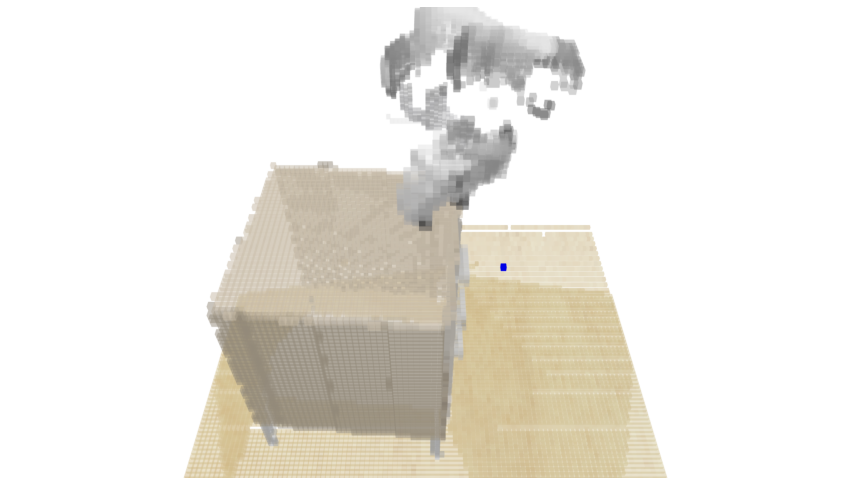

In [ ]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               vis_gt_coord[0],
                               voxel_size=0.045,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')

print(f"Lang goal: {lang_goal}")

This visualization shows a voxel grid of size 100x100x100 = 1 million voxels, and one expert keyframe action (blue voxel). These samples are what PerAct is trained with. Given a language goal and voxel grid, we train a detector to detect the next best action with supervised learning.

### PerceiverIO

Now we can start implementing the actual Transformer backbone of PerAct from **Section 3.3**.

The input grid is 100×100×100 = 1 million voxels. If we extract 5×5×5 patches, the input is still 20×20×20 = 8000 embeddings long. This sequence is way too long for a standard Transformer with O(n^2) self-attention connections. So we use the [PerceiverIO architecture](https://arxiv.org/abs/2107.14795) instead.  

Perceiver uses a small set of **latent vectors** to encode the input. These latent vectors are randomly initialized and trained end-to-end. This approach decouples the depth of the Transformer self-attention layers from the dimensionality of the input space, which allows us train PerAct on very large input voxel grids. We can potentially scale the input to 200^3 voxels without increasing self-attention layer parameters.

Refer to **Appendix B** in the paper for additional details.

<div>
<img src="https://peract.github.io/media/figures/perceiver.png" alt="drawing"  width="600"/>
</div>

But first, let's define some helper functions to implement the attention mechanism:

In [ ]:
# From: https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_io.py

from math import pi, log
from functools import wraps

from einops import rearrange, repeat, reduce
from einops.layers.torch import Reduce

from arm.network_utils import Conv3DInceptionBlock, DenseBlock, SpatialSoftmax3D, Conv3DInceptionBlockUpsampleBlock, Conv3DBlock, Conv3DUpsampleBlock


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def cache_fn(f):
    cache = None

    @wraps(f)
    def cached_fn(*args, _cache=True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache

    return cached_fn


class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)

        return self.fn(x, **kwargs)


class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module): # is all you need. Living up to its name.
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention
        attn = sim.softmax(dim=-1)

        # dropout
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

We use these attention modules to construct PerceiverIO:

In [ ]:
# PerceiverIO adapted for 6-DoF manipulation

class PerceiverIO(nn.Module):
    def __init__(
            self,
            depth,                    # number of self-attention layers
            iterations,               # number cross-attention iterations (PerceiverIO uses just 1)
            voxel_size,               # N voxels per side (size: N*N*N)
            initial_dim,              # 10 dimensions - dimension of the input sequence to be encoded
            low_dim_size,             # 4 dimensions - proprioception: {gripper_open, left_finger_joint, right_finger_joint, timestep}
            layer=0,
            num_rotation_classes=72,  # 5 degree increments (5*72=360) for each of the 3-axis
            num_grip_classes=2,       # open or not open
            num_collision_classes=2,  # collisions allowed or not allowed
            input_axis=3,             # 3D tensors have 3 axes
            num_latents=512,          # number of latent vectors
            im_channels=64,           # intermediate channel size
            latent_dim=512,           # dimensions of latent vectors
            cross_heads=1,            # number of cross-attention heads
            latent_heads=8,           # number of latent heads
            cross_dim_head=64,
            latent_dim_head=64,
            activation='relu',
            weight_tie_layers=False,
            input_dropout=0.1,
            attn_dropout=0.1,
            decoder_dropout=0.0,
            voxel_patch_size=5,       # intial patch size
            voxel_patch_stride=5,     # initial stride to patchify voxel input
            final_dim=64,             # final dimensions of features
    ):
        super().__init__()
        self.depth = depth
        self.layer = layer
        self.init_dim = int(initial_dim)
        self.iterations = iterations
        self.input_axis = input_axis
        self.voxel_size = voxel_size
        self.low_dim_size = low_dim_size
        self.im_channels = im_channels
        self.voxel_patch_size = voxel_patch_size
        self.voxel_patch_stride = voxel_patch_stride
        self.num_rotation_classes = num_rotation_classes
        self.num_grip_classes = num_grip_classes
        self.num_collision_classes = num_collision_classes
        self.final_dim = final_dim
        self.input_dropout = input_dropout
        self.attn_dropout = attn_dropout
        self.decoder_dropout = decoder_dropout

        # patchified input dimensions
        spatial_size = voxel_size // self.voxel_patch_stride # 100/5 = 20

        # 64 voxel features + 64 proprio features
        self.input_dim_before_seq = self.im_channels * 2

        # learnable positional encoding
        lang_emb_dim, lang_max_seq_len = 512, 77
        self.pos_encoding = nn.Parameter(torch.randn(1,
                                                     lang_max_seq_len+spatial_size**3,
                                                     self.input_dim_before_seq))

        # voxel input preprocessing encoder
        self.input_preprocess = Conv3DBlock(
            self.init_dim, self.im_channels, kernel_sizes=1, strides=1,
            norm=None, activation=activation,
        )

        # proprio preprocessing encoder
        self.proprio_preprocess = DenseBlock(
            self.low_dim_size, self.im_channels, norm=None, activation=activation,
        )

        # patchify conv
        self.patchify = Conv3DBlock(
            self.input_preprocess.out_channels, self.im_channels,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation)

        # lang preprocess
        self.lang_preprocess = nn.Linear(lang_emb_dim, self.im_channels * 2)

        # pooling functions
        self.local_maxp = nn.MaxPool3d(3, 2, padding=1)
        self.global_maxp = nn.AdaptiveMaxPool3d(1)

        # 1st 3D softmax
        self.ss0 = SpatialSoftmax3D(
            self.voxel_size, self.voxel_size, self.voxel_size,
            self.im_channels)
        flat_size = self.im_channels * 4

        # latent vectors (that are randomly initialized)
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        # encoder cross attention
        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim, self.input_dim_before_seq, heads=cross_heads,
                                          dim_head=cross_dim_head, dropout=input_dropout),
                    context_dim=self.input_dim_before_seq),
            PreNorm(latent_dim, FeedForward(latent_dim))
        ])

        get_latent_attn = lambda: PreNorm(latent_dim,
                                          Attention(latent_dim, heads=latent_heads,
                                                    dim_head=latent_dim_head, dropout=attn_dropout))
        get_latent_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim))
        get_latent_attn, get_latent_ff = map(cache_fn, (get_latent_attn, get_latent_ff))

        # self-attention layers
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                get_latent_attn(**cache_args),
                get_latent_ff(**cache_args)
            ]))

        # decoder cross attention
        self.decoder_cross_attn = PreNorm(self.input_dim_before_seq, Attention(self.input_dim_before_seq, latent_dim, heads=cross_heads,
                                                                      dim_head=cross_dim_head,
                                                                      dropout=decoder_dropout),
                                          context_dim=latent_dim)

        # upsample conv
        self.up0 = Conv3DUpsampleBlock(
            self.input_dim_before_seq, self.final_dim,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation,
        )

        # 2nd 3D softmax
        self.ss1 = SpatialSoftmax3D(
            spatial_size, spatial_size, spatial_size,
            self.input_dim_before_seq)

        flat_size += self.input_dim_before_seq * 4

        # final layers
        self.final = Conv3DBlock(
            self.im_channels * 2,
            self.im_channels,
            kernel_sizes=3,
            strides=1, norm=None, activation=activation)

        # 100x100x100x64 -> 100x100x100x1 decoder for translation Q-values
        self.trans_decoder = Conv3DBlock(
            self.final_dim, 1, kernel_sizes=3, strides=1,
            norm=None, activation=None,
        )

        # final 3D softmax
        self.ss_final = SpatialSoftmax3D(
            self.voxel_size, self.voxel_size, self.voxel_size,
            self.im_channels)

        flat_size += self.im_channels * 4

        # MLP layers
        self.dense0 =  DenseBlock(
            flat_size, 256, None, activation)
        self.dense1 = DenseBlock(
            256, self.final_dim, None, activation)

        # 1x64 -> 1x(72+72+72+2+2) decoders for rotation, gripper open, and collision Q-values
        self.rot_grip_collision_ff = DenseBlock(self.final_dim,
                                          self.num_rotation_classes * 3 + \
                                          self.num_grip_classes + \
                                          self.num_collision_classes,
                                          None, None)

    def forward(
            self,
            ins,
            proprio,
            lang_goal_embs,
            bounds,
            mask=None,
    ):
        # preprocess
        d0 = self.input_preprocess(ins)               # [B,10,100,100,100] -> [B,64,100,100,100]

        # aggregated features from 1st softmax and maxpool for MLP decoders
        feats = [self.ss0(d0.contiguous()), self.global_maxp(d0).view(ins.shape[0], -1)]

        # patchify input (5x5x5 patches)
        ins = self.patchify(d0)                       # [B,64,100,100,100] -> [B,64,20,20,20]

        b, c, d, h, w, device = *ins.shape, ins.device
        axis = [d, h, w]
        assert len(axis) == self.input_axis, 'input must have the same number of axis as input_axis'

        # concat proprio
        p = self.proprio_preprocess(proprio)          # [B,4] -> [B,64]
        p = p.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, d, h, w)
        ins = torch.cat([ins, p], dim=1)              # [B,128,20,20,20]

        # channel last
        ins = rearrange(ins, 'b d ... -> b ... d')    # [B,20,20,20,128]

        # save original shape of input for layer
        ins_orig_shape = ins.shape

        # flatten voxel grid into sequence
        ins = rearrange(ins, 'b ... d -> b (...) d')  # [B,8000,128]

        # append language features as sequence
        l = self.lang_preprocess(lang_goal_embs)      # [B,77,1024] -> [B,77,128]
        ins = torch.cat((l, ins), dim=1)              # [B,8077,128]

        # add learable pos encoding
        ins = ins + self.pos_encoding

        # batchify latents
        x = repeat(self.latents, 'n d -> b n d', b=b)

        cross_attn, cross_ff = self.cross_attend_blocks

        for it in range(self.iterations):
            # encoder cross attention
            x = cross_attn(x, context=ins, mask=mask) + x
            x = cross_ff(x) + x

            # self-attention layers
            for self_attn, self_ff in self.layers:
                x = self_attn(x) + x
                x = self_ff(x) + x

        # decoder cross attention
        latents = self.decoder_cross_attn(ins, context=x)
        latents = latents[:, l.shape[1]:]

        # reshape back to voxel grid
        latents = latents.view(b, *ins_orig_shape[1:-1], latents.shape[-1])  # [B,20,20,20,64]
        latents = rearrange(latents, 'b ... d -> b d ...')                   # [B,64,20,20,20]

        # aggregated features from 2nd softmax and maxpool for MLP decoders
        feats.extend([self.ss1(latents.contiguous()), self.global_maxp(latents).view(b, -1)])

        # upsample layer
        u0 = self.up0(latents)                         # [B,64,100,100,100]

        # skip connection like in UNets
        u = self.final(torch.cat([d0, u0], dim=1))     # [B,64+64,100,100,100] -> [B,64,100,100,100]

        # translation decoder
        trans = self.trans_decoder(u)                  # [B,64,100,100,100] -> [B,1,100,100,100]

        # aggregated features from final softmax and maxpool for MLP decoders
        feats.extend([self.ss_final(u.contiguous()), self.global_maxp(u).view(b, -1)])

        # decoder MLP layers for rotation, gripper open, and collision
        dense0 = self.dense0(torch.cat(feats, dim=1))
        dense1 = self.dense1(dense0)                   # [B,72*3+2+2]

        # format output
        rot_and_grip_collision_out = self.rot_grip_collision_ff(dense1)
        rot_and_grip_out = rot_and_grip_collision_out[:, :-self.num_collision_classes]
        collision_out = rot_and_grip_collision_out[:, -self.num_collision_classes:]

        return trans, rot_and_grip_out, collision_out


# initialize PerceiverIO Transformer
perceiver_encoder = PerceiverIO(
    depth=6,
    iterations=1,
    voxel_size=VOXEL_SIZES[0],
    initial_dim=3 + 3 + 1 + 3,
    low_dim_size=4,
    layer=0,
    num_rotation_classes=72,
    num_grip_classes=2,
    num_collision_classes=2,
    num_latents=NUM_LATENTS,
    latent_dim=512,
    cross_heads=1,
    latent_heads=8,
    cross_dim_head=64,
    latent_dim_head=64,
    weight_tie_layers=False,
    activation='lrelu',
    input_dropout=0.1,
    attn_dropout=0.1,
    decoder_dropout=0.0,
    voxel_patch_size=5,
    voxel_patch_stride=5,
    final_dim=64,
)

### Q Functions

Finally we put everything together to make PerAct's Q-Functions.  

This module voxelizes RGB-D input, encodes per-voxel features, and predicts discretized actions.  

<div>
<img src="https://peract.github.io/media/figures/arch.png" alt="drawing"  width="1000"/>
</div>

In [ ]:
import copy

class QFunction(nn.Module):

    def __init__(self,
                 perceiver_encoder: nn.Module,
                 voxel_grid: VoxelGrid,
                 rotation_resolution: float,
                 device,
                 training):
        super(QFunction, self).__init__()
        self._rotation_resolution = rotation_resolution
        self._voxel_grid = voxel_grid
        self._qnet = copy.deepcopy(perceiver_encoder)
        self._qnet._dev = device

    def _argmax_3d(self, tensor_orig):
        b, c, d, h, w = tensor_orig.shape  # c will be one
        idxs = tensor_orig.view(b, c, -1).argmax(-1)
        indices = torch.cat([((idxs // h) // d), (idxs // h) % w, idxs % w], 1)
        return indices

    def choose_highest_action(self, q_trans, q_rot_grip, q_collision):
        coords = self._argmax_3d(q_trans)
        rot_and_grip_indicies = None
        if q_rot_grip is not None:
            q_rot = torch.stack(torch.split(
                q_rot_grip[:, :-2],
                int(360 // self._rotation_resolution),
                dim=1), dim=1)
            rot_and_grip_indicies = torch.cat(
                [q_rot[:, 0:1].argmax(-1),
                 q_rot[:, 1:2].argmax(-1),
                 q_rot[:, 2:3].argmax(-1),
                 q_rot_grip[:, -2:].argmax(-1, keepdim=True)], -1)
            ignore_collision = q_collision[:, -2:].argmax(-1, keepdim=True)
        return coords, rot_and_grip_indicies, ignore_collision

    def forward(self,
                obs,
                proprio,
                pcd,
                lang_goal_embs,
                bounds=None):

        # flatten point cloud
        bs = obs[0][0].shape[0]
        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcd], 1)

        # flatten rgb
        image_features = [o[0] for o in obs]
        feat_size = image_features[0].shape[1]
        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in
             image_features], 1)

        # voxelize
        voxel_grid = self._voxel_grid.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds)

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach()

        # batch bounds if necessary
        if bounds.shape[0] != bs:
            bounds = bounds.repeat(bs, 1)

        # forward pass
        q_trans, rot_and_grip_q, collision_q = self._qnet(voxel_grid,
                                                          proprio,
                                                          lang_goal_embs,
                                                          bounds)
        return q_trans, rot_and_grip_q, collision_q, voxel_grid

    def latents(self):
        return self._qnet.latent_dict

### PerAct Agent

Let's initialize PerAct and define an update function for the training loop.

The keyframe actions used for supervision are represented as one-hot vectors. Then we use cross-entropy loss to train PerAct, just like a standard classifier. This training method is also closely related to [Energy-Based Models (EBMs)](https://arxiv.org/abs/2109.00137).

In [ ]:
from arm.optim.lamb import Lamb
from arm.utils import stack_on_channel


class PerceiverActorAgent():
    def __init__(self,
                coordinate_bounds: list,
                perceiver_encoder: nn.Module,
                camera_names: list,
                batch_size: int,
                voxel_size: int,
                voxel_feature_size: int,
                num_rotation_classes: int,
                rotation_resolution: float,
                lr: float = 0.0001,
                image_resolution: list = None,
                lambda_weight_l2: float = 0.0,
                transform_augmentation: bool = True,
                transform_augmentation_xyz: list = [0.0, 0.0, 0.0],
                transform_augmentation_rpy: list = [0.0, 0.0, 180.0],
                transform_augmentation_rot_resolution: int = 5,
                optimizer_type: str = 'lamb'):

        self._coordinate_bounds = coordinate_bounds
        self._perceiver_encoder = perceiver_encoder
        self._camera_names = camera_names
        self._batch_size = batch_size
        self._voxel_size = voxel_size
        self._voxel_feature_size = voxel_feature_size
        self._num_rotation_classes = num_rotation_classes
        self._rotation_resolution = rotation_resolution
        self._lr = lr
        self._image_resolution = image_resolution
        self._lambda_weight_l2 = lambda_weight_l2
        self._transform_augmentation = transform_augmentation
        self._transform_augmentation_xyz = transform_augmentation_xyz
        self._transform_augmentation_rpy = transform_augmentation_rpy
        self._transform_augmentation_rot_resolution = transform_augmentation_rot_resolution
        self._optimizer_type = optimizer_type

        self._cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

    def build(self, training: bool, device: torch.device = None):
        self._training = training
        self._device = device

        vox_grid = VoxelGrid(
            coord_bounds=self._coordinate_bounds,
            voxel_size=self._voxel_size,
            device=device,
            batch_size=self._batch_size,
            feature_size=self._voxel_feature_size,
            max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
        )
        self._vox_grid = vox_grid

        self._q = QFunction(self._perceiver_encoder,
                            vox_grid,
                            self._rotation_resolution,
                            device,
                            training).to(device).train(training)

        self._coordinate_bounds = torch.tensor(self._coordinate_bounds,
                                               device=device).unsqueeze(0)

        if self._optimizer_type == 'lamb':
            # From: https://github.com/cybertronai/pytorch-lamb/blob/master/pytorch_lamb/lamb.py
            self._optimizer = Lamb(
                self._q.parameters(),
                lr=self._lr,
                weight_decay=self._lambda_weight_l2,
                betas=(0.9, 0.999),
                adam=False,
            )
        elif self._optimizer_type == 'adam':
            self._optimizer = torch.optim.Adam(
                self._q.parameters(),
                lr=self._lr,
                weight_decay=self._lambda_weight_l2,
            )
        else:
            raise Exception('Unknown optimizer')

    def _softmax_q(self, q):
        q_shape = q.shape
        return F.softmax(q.reshape(q_shape[0], -1), dim=1).reshape(q_shape)

    def _get_one_hot_expert_actions(self,  # You don't really need this function since GT labels are already in the right format. This is some leftover code from my experiments with label smoothing.
                                    batch_size,
                                    action_trans,
                                    action_rot_grip,
                                    action_ignore_collisions,
                                    device):
        bs = batch_size

        # initialize with zero tensors
        action_trans_one_hot = torch.zeros((bs, self._voxel_size, self._voxel_size, self._voxel_size), dtype=int, device=device)
        action_rot_x_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_rot_y_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_rot_z_one_hot = torch.zeros((bs, self._num_rotation_classes), dtype=int, device=device)
        action_grip_one_hot  = torch.zeros((bs, 2), dtype=int, device=device)
        action_collision_one_hot = torch.zeros((bs, 2), dtype=int, device=device)

        # fill one-hots
        for b in range(bs):
          # translation
          gt_coord = action_trans[b, :]
          action_trans_one_hot[b, gt_coord[0], gt_coord[1], gt_coord[2]] = 1

          # rotation
          gt_rot_grip = action_rot_grip[b, :]
          action_rot_x_one_hot[b, gt_rot_grip[0]] = 1
          action_rot_y_one_hot[b, gt_rot_grip[1]] = 1
          action_rot_z_one_hot[b, gt_rot_grip[2]] = 1
          action_grip_one_hot[b, gt_rot_grip[3]] = 1

          # ignore collision
          gt_ignore_collisions = action_ignore_collisions[b, :]
          action_collision_one_hot[b, gt_ignore_collisions[0]] = 1

        # flatten trans
        action_trans_one_hot = action_trans_one_hot.view(bs, -1)

        return action_trans_one_hot, \
               action_rot_x_one_hot, \
               action_rot_y_one_hot, \
               action_rot_z_one_hot, \
               action_grip_one_hot,  \
               action_collision_one_hot


    def update(self, step: int, replay_sample: dict, backprop: bool = True) -> dict:
        # sample
        action_trans = replay_sample['trans_action_indicies'][:, -1, :3].int()
        action_rot_grip = replay_sample['rot_grip_action_indicies'][:, -1].int()
        action_ignore_collisions = replay_sample['ignore_collisions'][:, -1].int()
        action_gripper_pose = replay_sample['gripper_pose'][:, -1]
        lang_goal_embs = replay_sample['lang_goal_embs'][:, -1].float()

        # metric scene bounds
        bounds = bounds_tp1 = self._coordinate_bounds

        # inputs
        proprio = stack_on_channel(replay_sample['low_dim_state'])
        obs, pcd = _preprocess_inputs(replay_sample)

        # TODO: data augmentation by applying SE(3) pertubations to pcd and actions
        # see https://github.com/peract/peract/blob/main/voxel/augmentation.py#L68 for reference

        # Q function
        q_trans, rot_grip_q, collision_q, voxel_grid = self._q(obs,
                                                               proprio,
                                                               pcd,
                                                               lang_goal_embs,
                                                               bounds)

        # one-hot expert actions
        bs = self._batch_size
        action_trans_one_hot, action_rot_x_one_hot, \
        action_rot_y_one_hot, action_rot_z_one_hot, \
        action_grip_one_hot, action_collision_one_hot = self._get_one_hot_expert_actions(bs,
                                                                                         action_trans,
                                                                                         action_rot_grip,
                                                                                         action_ignore_collisions,
                                                                                         device=self._device)
        total_loss = 0.
        if backprop:
            # cross-entropy loss
            trans_loss = self._cross_entropy_loss(q_trans.view(bs, -1),
                                                  action_trans_one_hot.argmax(-1))

            rot_grip_loss = 0.
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 0*self._num_rotation_classes:1*self._num_rotation_classes],
                                                      action_rot_x_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 1*self._num_rotation_classes:2*self._num_rotation_classes],
                                                      action_rot_y_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 2*self._num_rotation_classes:3*self._num_rotation_classes],
                                                      action_rot_z_one_hot.argmax(-1))
            rot_grip_loss += self._cross_entropy_loss(rot_grip_q[:, 3*self._num_rotation_classes:],
                                                      action_grip_one_hot.argmax(-1))

            collision_loss = self._cross_entropy_loss(collision_q,
                                                      action_collision_one_hot.argmax(-1))

            total_loss = trans_loss + rot_grip_loss + collision_loss
            total_loss = total_loss.mean()

            # backprop
            self._optimizer.zero_grad()
            total_loss.backward()
            self._optimizer.step()

            total_loss = total_loss.item()

        # choose best action through argmax
        coords_indicies, rot_and_grip_indicies, ignore_collision_indicies = self._q.choose_highest_action(q_trans,
                                                                                                          rot_grip_q,
                                                                                                          collision_q)

        # discrete to continuous translation action
        res = (bounds[:, 3:] - bounds[:, :3]) / self._voxel_size
        continuous_trans = bounds[:, :3] + res * coords_indicies.int() + res / 2

        return {
            'total_loss': total_loss,
            'voxel_grid': voxel_grid,
            'q_trans': self._softmax_q(q_trans),
            'pred_action': {
                'trans': coords_indicies,
                'continuous_trans': continuous_trans,
                'rot_and_grip': rot_and_grip_indicies,
                'collision': ignore_collision_indicies
            },
            'expert_action': {
                'action_trans': action_trans
            }
        }

# initialize PerceiverActor
peract_agent = PerceiverActorAgent(
    coordinate_bounds=SCENE_BOUNDS,
    perceiver_encoder=perceiver_encoder,
    camera_names=CAMERAS,
    batch_size=BATCH_SIZE,
    voxel_size=VOXEL_SIZES[0],
    voxel_feature_size=3,
    num_rotation_classes=72,
    rotation_resolution=5,
    lr=0.0001,
    image_resolution=[IMAGE_SIZE, IMAGE_SIZE],
    lambda_weight_l2=0.000001,
    transform_augmentation=False,
    optimizer_type='lamb',
)
peract_agent.build(training=True, device=device)

### Training Loop

The final training loop samples data from the replay buffer and trains the agent with supervised learning. 2400 iterations should take ~130mins.

❗2400 iterations is probably not enough for robust performance, so you might see some weird predictions. Training for longer periods, particularly with data augmentation (see **Appendix E**), will improve performance. But we will stick with this for now to avoid Colab timeouts.

In [ ]:
import time

LOG_FREQ = 50
TRAINING_ITERATIONS = 2400

start_time = time.time()
for iteration in range(TRAINING_ITERATIONS):
    batch = next(train_data_iter)
    batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
    update_dict = peract_agent.update(iteration, batch)

    if iteration % LOG_FREQ == 0:
      elapsed_time = (time.time() - start_time) / 60.0
      print("Total Loss: %f | Elapsed Time: %f mins" % (update_dict['total_loss'], elapsed_time))

Total Loss: 27.779249 | Elapsed Time: 0.054984 mins
Total Loss: 26.278015 | Elapsed Time: 2.907965 mins
Total Loss: 25.842241 | Elapsed Time: 5.846650 mins
Total Loss: 25.331209 | Elapsed Time: 8.784196 mins
Total Loss: 24.273756 | Elapsed Time: 11.726737 mins
Total Loss: 17.772348 | Elapsed Time: 14.671282 mins
Total Loss: 16.773046 | Elapsed Time: 17.615427 mins
Total Loss: 15.906282 | Elapsed Time: 20.558495 mins
Total Loss: 16.009947 | Elapsed Time: 23.501965 mins
Total Loss: 17.832920 | Elapsed Time: 26.439574 mins
Total Loss: 16.000391 | Elapsed Time: 29.380248 mins
Total Loss: 13.054528 | Elapsed Time: 32.324358 mins
Total Loss: 14.945177 | Elapsed Time: 35.268612 mins
Total Loss: 12.704187 | Elapsed Time: 38.212549 mins
Total Loss: 15.300818 | Elapsed Time: 41.147471 mins
Total Loss: 14.226664 | Elapsed Time: 44.092694 mins
Total Loss: 15.379484 | Elapsed Time: 47.033580 mins
Total Loss: 14.514743 | Elapsed Time: 49.976848 mins
Total Loss: 12.732193 | Elapsed Time: 52.919522 mi

## Inference and Visualization

Let's see how PerAct does on held-out test data.  

PerAct should be evaluated in simulation on scenes with randomized object poses and object instances. But this Colab notebook doesn't support the V-REP simulator (for RLBench tasks). So for now we will do inference on a static test dataset.

In [ ]:
from arm.utils import visualise_voxel, discrete_euler_to_quaternion, get_gripper_render_pose
from scipy.spatial.transform import Rotation as R

batch = next(test_data_iter)
lang_goal = batch['lang_goal'][0][0][0]
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
update_dict = peract_agent.update(iteration, batch, backprop=False)

# things to visualize
vis_voxel_grid = update_dict['voxel_grid'][0].detach().cpu().numpy()
vis_trans_q = update_dict['q_trans'][0].detach().cpu().numpy()
vis_trans_coord = update_dict['pred_action']['trans'][0].detach().cpu().numpy()
vis_gt_coord = update_dict['expert_action']['action_trans'][0].detach().cpu().numpy()

# discrete to continuous
continuous_trans = update_dict['pred_action']['continuous_trans'][0].detach().cpu().numpy()
continuous_quat = discrete_euler_to_quaternion(update_dict['pred_action']['rot_and_grip'][0][:3].detach().cpu().numpy(),
                                               resolution=peract_agent._rotation_resolution)
gripper_open = bool(update_dict['pred_action']['rot_and_grip'][0][-1].detach().cpu().numpy())
ignore_collision = bool(update_dict['pred_action']['collision'][0][0].detach().cpu().numpy())

# gripper visualization pose
voxel_size = 0.045
voxel_scale = voxel_size * 100
gripper_pose_mat = get_gripper_render_pose(voxel_scale,
                                           SCENE_BOUNDS[:3],
                                           continuous_trans,
                                           continuous_quat)

Lang Goal: open the bottom drawer


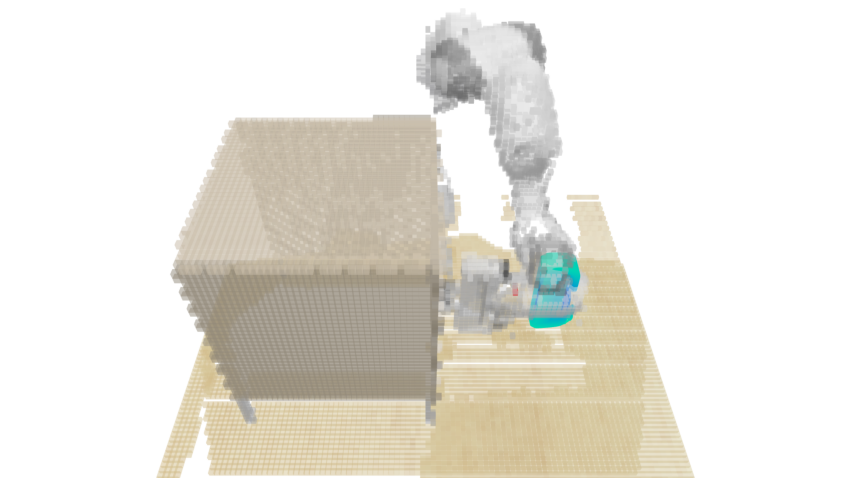

In [ ]:
#@markdown #### Show Q-Prediction and Best Action
show_expert_action = False  #@param {type:"boolean"}
show_q_values = True  #@param {type:"boolean"}
render_gripper = True  #@param {type:"boolean"}
rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}

rendered_img = visualise_voxel(vis_voxel_grid,
                               vis_trans_q if show_q_values else None,
                               vis_trans_coord,
                               vis_gt_coord if show_expert_action else None,
                               voxel_size=voxel_size,
                               rotation_amount=np.deg2rad(rotation_amount),
                               render_gripper=render_gripper,
                               gripper_pose=gripper_pose_mat,
                               gripper_mesh_scale=voxel_scale)

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')

print(f"Lang Goal: {lang_goal}")

The red values are normalized translation Q-predictions (they might be barely visible if the distribution is peaky). The blue voxel is the expert keyframe action. And the turquoise gripper (without fingers) is the 6-DoF action with the highest Q-values.

That's it! 🎉 Now use your favorite motion-planner to reach the 6-DoF pose. Once the pose is reached, you can repeat the process again with the new observation until the desired goal has been reached.

The full implementation is not that different to what has been covered in this notebook. Major differences include: the replay buffer is loaded with lots of tasks, the agent is trained with larger batch-sizes by using multiple GPUs, and the agent is trained for a much longer period (with data augmentation) to optimize on all the tasks.

This framework might be applicable to problems beyond just single-arm manipulation. For instance, you can predict two gripper poses for bimanual manipulation, or waypoint poses for navigation, or foothold poses for legged locomotion.

## Citations

**PerAct**
```
@inproceedings{shridhar2022peract,
  title     = {Perceiver-Actor: A Multi-Task Transformer for Robotic Manipulation},
  author    = {Shridhar, Mohit and Manuelli, Lucas and Fox, Dieter},
  booktitle = {Proceedings of the 6th Conference on Robot Learning (CoRL)},
  year      = {2022},
}
```

**C2FARM**
```
@inproceedings{james2022coarse,
  title={Coarse-to-fine q-attention: Efficient learning for visual robotic manipulation via discretisation},
  author={James, Stephen and Wada, Kentaro and Laidlow, Tristan and Davison, Andrew J},
  booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition},
  pages={13739--13748},
  year={2022}
}
```

**PerceiverIO**
```
@article{jaegle2021perceiver,
  title={Perceiver io: A general architecture for structured inputs \& outputs},
  author={Jaegle, Andrew and Borgeaud, Sebastian and Alayrac, Jean-Baptiste and Doersch, Carl and Ionescu, Catalin and Ding, David and Koppula, Skanda and Zoran, Daniel and Brock, Andrew and Shelhamer, Evan and others},
  journal={arXiv preprint arXiv:2107.14795},
  year={2021}
}
```


**RLBench**
```
@article{james2020rlbench,
  title={Rlbench: The robot learning benchmark \& learning environment},
  author={James, Stephen and Ma, Zicong and Arrojo, David Rovick and Davison, Andrew J},
  journal={IEEE Robotics and Automation Letters},
  volume={5},
  number={2},
  pages={3019--3026},
  year={2020},
  publisher={IEEE}
}
```